In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:

# Load the dataset
df = pd.read_csv(r'C:\Users\25645\OneDrive\文档\GitHub\demand-skill-analysis-based-on-Linkedin\postings.csv')

# Select relevant columns
df = df[['description', 'max_salary', 'min_salary']]

# Drop rows with missing values in key columns (if any)
df.dropna(subset=['description', 'max_salary', 'min_salary'], inplace=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Text cleaning function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags or other markup if present
    text = re.sub(r'<[^>]+>', ' ', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Tokenize by splitting on whitespace
    tokens = text.split()
    # Remove stopwords and short tokens, and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

# Apply preprocessing to the job descriptions
df['tokens'] = df['description'].apply(preprocess_text)

# Preview the results
print("Sample tokens from a job description:")
print(df['tokens'].iloc[0][:20])  # print first 20 tokens of the first job description



Sample tokens from a job description:
['job', 'descriptiona', 'leading', 'real', 'estate', 'firm', 'new', 'jersey', 'seeking', 'administrative', 'marketing', 'coordinator', 'experience', 'graphic', 'design', 'working', 'closely', 'fun', 'kind', 'ambitious']


In [3]:
# Function to normalize salaries to monthly scale
def normalize_salary(salary):
    if salary < 1000:  # Hourly wage
        return salary * 160  # Convert to monthly salary
    elif salary > 13000:  # Yearly salary
        return salary / 12  # Convert to monthly salary
    return salary  # Already in monthly salary

# Apply salary normalization
df['max_salary'] = df['max_salary'].apply(normalize_salary)
df['min_salary'] = df['min_salary'].apply(normalize_salary)

# Check salary transformation
print(df[['max_salary', 'min_salary']].describe())


         max_salary    min_salary
count  2.979200e+04  2.979200e+04
mean   1.006962e+04  7.358906e+03
std    5.826091e+04  4.122411e+04
min    1.600000e+02  1.600000e+02
25%    5.416667e+03  4.160000e+03
50%    8.333333e+03  6.250000e+03
75%    1.250000e+04  9.166667e+03
max    1.000000e+07  7.083333e+06


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Join tokens back into strings for vectorization
df['clean_desc'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

vectorizer_tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer_tfidf.fit_transform(df['clean_desc'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer_tfidf.get_feature_names_out())

df = pd.concat([df, tfidf_df], axis=1)


In [ ]:
import pickle
with open("tfidf_vectorizer.pkl", "wb") as tfidf_file:
    pickle.dump(vectorizer_tfidf, tfidf_file)
print(" TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'")


✅ TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'
✅ Transformed dataset saved as 'processed_tfidf_data.csv'


In [6]:
from gensim.models import Word2Vec
df['tokens'] = df['tokens'].apply(lambda x: x if isinstance(x, list) else [])
df['tokens'] = df['tokens'].apply(lambda tokens: [str(word) for word in tokens if isinstance(word, str)])

# Train a Word2Vec model on the token lists
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=300, window=5, min_count=5, workers=24, sg=1)  




In [7]:
def get_avg_word2vec(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv] 
    if len(vectors) > 0:
        return np.mean(vectors, axis=0) 
    else:
        return np.zeros(vector_size)  

df['word2vec_vector'] = df['tokens'].apply(lambda tokens: get_avg_word2vec(tokens, w2v_model, 300))



In [8]:
import numpy as np

glove_path = r"C:\Users\25645\OneDrive\桌面\glove.6B.100d.txt"  
glove_embeddings = {}
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]  # 词
        vector = np.array(values[1:], dtype=np.float32) 
        glove_embeddings[word] = vector


def get_avg_glove_vector(tokens, embeddings, vector_size=100):
    if not isinstance(tokens, list):  
        return np.zeros(vector_size)  

    vectors = [embeddings[word] for word in tokens if isinstance(word, str) and word in embeddings]  
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)  
    else:
        return np.zeros(vector_size)  

df['tokens'] = df['tokens'].apply(lambda x: x if isinstance(x, list) else [])

df['glove_vector'] = df['tokens'].apply(lambda tokens: get_avg_glove_vector(tokens, glove_embeddings, 100))

print(df['glove_vector'].head())




0    [0.006928094, 0.07466537, 0.04697802, -0.03438...
1    [0.0067222863, 0.13031681, -0.0041930927, 0.12...
2    [0.019395787, 0.1554178, 0.078248575, 0.005049...
3    [0.09678056, -0.06279582, 0.023229228, 0.11438...
4    [0.023841092, 0.184397, 0.09676967, -0.1540197...
Name: glove_vector, dtype: object


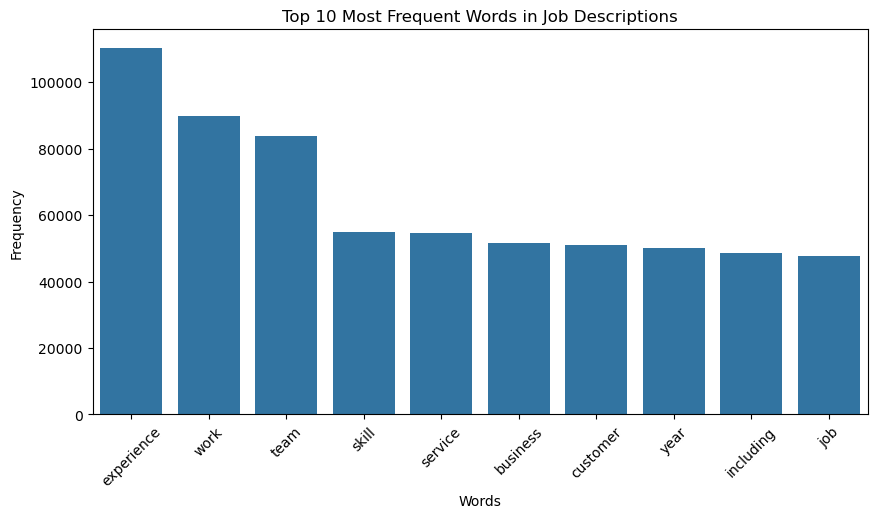

In [9]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

all_words = [word for tokens in df['tokens'] for word in tokens]  
word_counts = Counter(all_words)  
top_10_words = word_counts.most_common(10)  

plt.figure(figsize=(10,5))
sns.barplot(x=[word[0] for word in top_10_words], y=[word[1] for word in top_10_words])
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 10 Most Frequent Words in Job Descriptions")
plt.xticks(rotation=45)
plt.show()


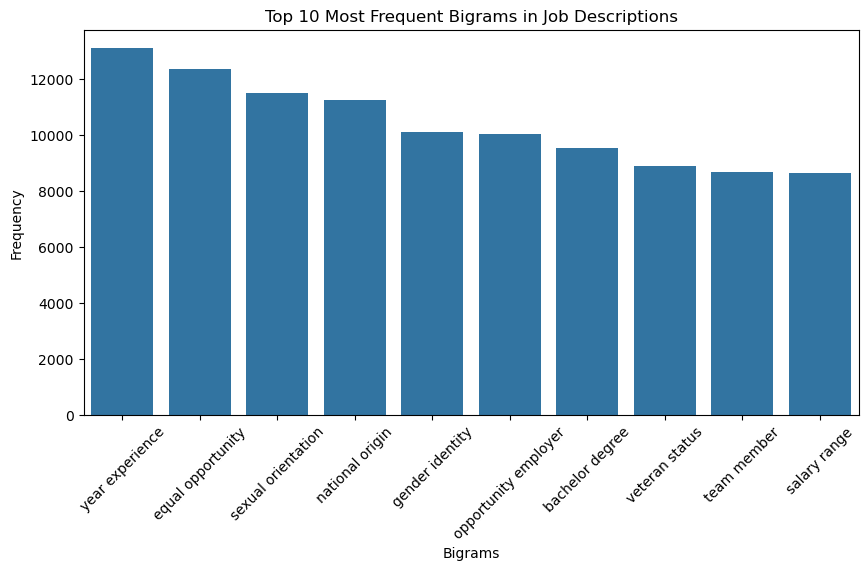

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
df['clean_desc'] = df['clean_desc'].fillna('')  
df['clean_desc'] = df['clean_desc'].astype(str) 
bigram_vectorizer = CountVectorizer(ngram_range=(2,2), max_features=1000)  
bigram_matrix = bigram_vectorizer.fit_transform(df['clean_desc'])  

bigram_counts = np.asarray(bigram_matrix.sum(axis=0)).ravel()
bigram_features = bigram_vectorizer.get_feature_names_out()
bigram_freq = list(zip(bigram_features, bigram_counts))
top_10_bigrams = sorted(bigram_freq, key=lambda x: x[1], reverse=True)[:10]

plt.figure(figsize=(10,5))
sns.barplot(x=[pair[0] for pair in top_10_bigrams], y=[pair[1] for pair in top_10_bigrams])
plt.xlabel("Bigrams")
plt.ylabel("Frequency")
plt.title("Top 10 Most Frequent Bigrams in Job Descriptions")
plt.xticks(rotation=45)
plt.show()


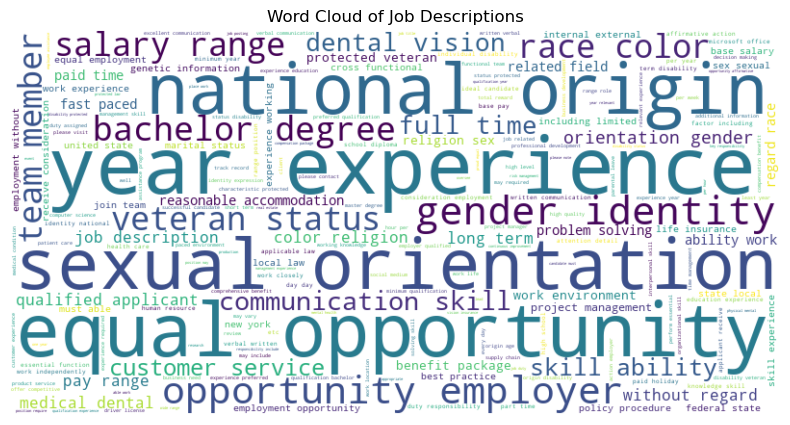

In [11]:
from wordcloud import WordCloud
all_text = " ".join(df['clean_desc'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Job Descriptions")
plt.show()


📌 Logistic Regression using TF-IDF:
AUC: 0.9136, F1-score: 0.8336

📌 Logistic Regression using Word2Vec:
AUC: 0.8833, F1-score: 0.8012

📌 Logistic Regression using GloVe:
AUC: 0.8327, F1-score: 0.7587



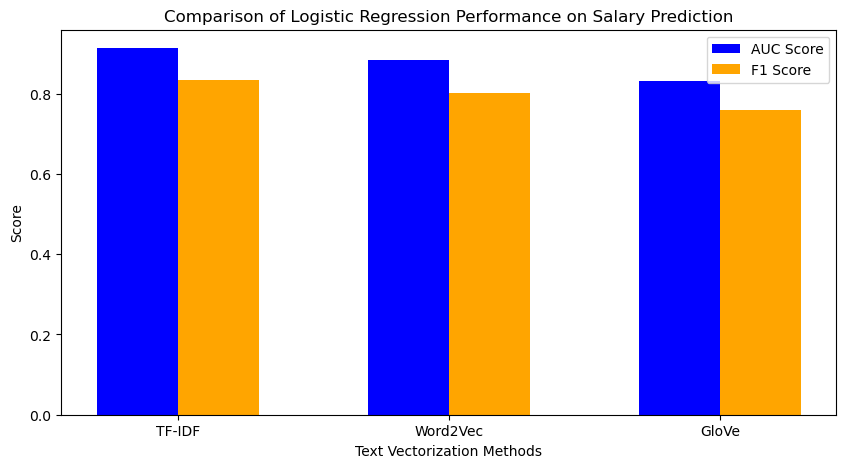

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler

df = df[['clean_desc', 'max_salary', 'min_salary']].dropna()

y_max = (df['max_salary'] > df['max_salary'].median()).astype(int) 
y_min = (df['min_salary'] > df['min_salary'].median()).astype(int)

X_train, X_test, y_train_max, y_test_max = train_test_split(df['clean_desc'], y_max, test_size=0.2, random_state=42)
X_train, X_test, y_train_min, y_test_min = train_test_split(df['clean_desc'], y_min, test_size=0.2, random_state=42)


X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)


def get_avg_w2v(tokens, model, vector_size=100):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

X_train_w2v = np.array([get_avg_w2v(text.split(), w2v_model) for text in X_train])
X_test_w2v = np.array([get_avg_w2v(text.split(), w2v_model) for text in X_test])


def get_avg_glove(tokens, embeddings, vector_size=100):
    vectors = [embeddings[word] for word in tokens if word in embeddings]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

X_train_glove = np.array([get_avg_glove(text.split(), glove_embeddings) for text in X_train])
X_test_glove = np.array([get_avg_glove(text.split(), glove_embeddings) for text in X_test])


def train_and_evaluate(X_train, X_test, y_train, y_test, method_name):
    model = LogisticRegression(max_iter=500)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_pred_prob)
    f1 = f1_score(y_test, y_pred)
    
    print(f"📌 Logistic Regression using {method_name}:")
    print(f"AUC: {auc:.4f}, F1-score: {f1:.4f}\n")
    
    return auc, f1

auc_tfidf, f1_tfidf = train_and_evaluate(X_train_tfidf, X_test_tfidf, y_train_max, y_test_max, "TF-IDF")

auc_w2v, f1_w2v = train_and_evaluate(X_train_w2v, X_test_w2v, y_train_max, y_test_max, "Word2Vec")

auc_glove, f1_glove = train_and_evaluate(X_train_glove, X_test_glove, y_train_max, y_test_max, "GloVe")


methods = ["TF-IDF", "Word2Vec", "GloVe"]
auc_scores = [auc_tfidf, auc_w2v, auc_glove]
f1_scores = [f1_tfidf, f1_w2v, f1_glove]

plt.figure(figsize=(10, 5))
x = np.arange(len(methods))
width = 0.3

plt.bar(x - width/2, auc_scores, width, label="AUC Score", color="blue")
plt.bar(x + width/2, f1_scores, width, label="F1 Score", color="orange")

plt.xticks(x, methods)
plt.xlabel("Text Vectorization Methods")
plt.ylabel("Score")
plt.title("Comparison of Logistic Regression Performance on Salary Prediction")
plt.legend()
plt.show()


📌 Random Forest using TF-IDF:
AUC: 0.9139, F1-score: 0.8289

📌 Random Forest using Word2Vec:
AUC: 0.9033, F1-score: 0.8222

📌 Random Forest using GloVe:
AUC: 0.8856, F1-score: 0.7984



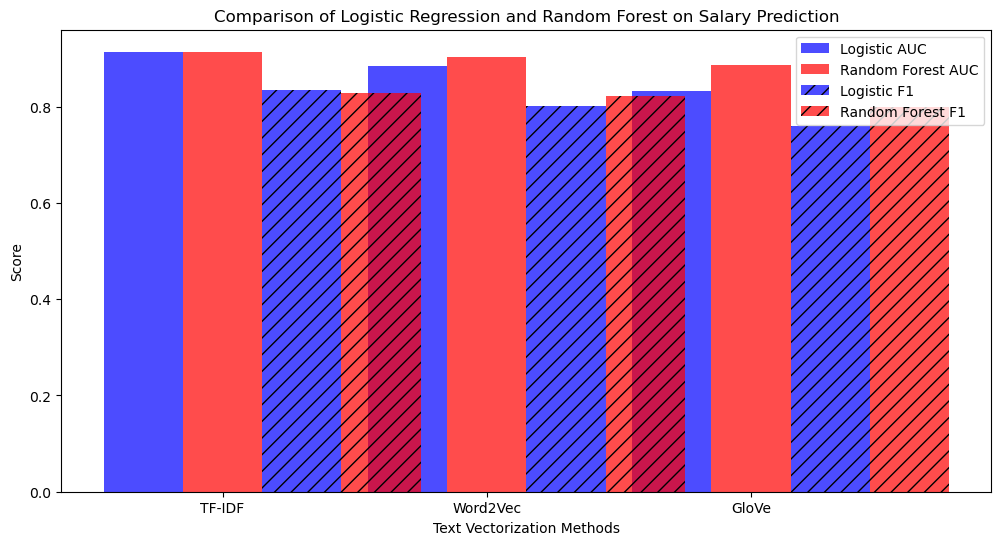

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score

def train_and_evaluate_rf(X_train, X_test, y_train, y_test, method_name):
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_pred_prob)
    f1 = f1_score(y_test, y_pred)

    print(f"📌 Random Forest using {method_name}:")
    print(f"AUC: {auc:.4f}, F1-score: {f1:.4f}\n")

    return auc, f1

auc_tfidf_rf, f1_tfidf_rf = train_and_evaluate_rf(X_train_tfidf, X_test_tfidf, y_train_max, y_test_max, "TF-IDF")

auc_w2v_rf, f1_w2v_rf = train_and_evaluate_rf(X_train_w2v, X_test_w2v, y_train_max, y_test_max, "Word2Vec")

auc_glove_rf, f1_glove_rf = train_and_evaluate_rf(X_train_glove, X_test_glove, y_train_max, y_test_max, "GloVe")


methods = ["TF-IDF", "Word2Vec", "GloVe"]
auc_logistic = [auc_tfidf, auc_w2v, auc_glove]
auc_rf = [auc_tfidf_rf, auc_w2v_rf, auc_glove_rf]
f1_logistic = [f1_tfidf, f1_w2v, f1_glove]
f1_rf = [f1_tfidf_rf, f1_w2v_rf, f1_glove_rf]

x = np.arange(len(methods))
width = 0.3

plt.figure(figsize=(12, 6))
plt.bar(x - width, auc_logistic, width, label="Logistic AUC", color="blue", alpha=0.7)
plt.bar(x, auc_rf, width, label="Random Forest AUC", color="red", alpha=0.7)
plt.bar(x + width, f1_logistic, width, label="Logistic F1", color="blue", hatch="//", alpha=0.7)
plt.bar(x + 2*width, f1_rf, width, label="Random Forest F1", color="red", hatch="//", alpha=0.7)

plt.xticks(x, methods)
plt.xlabel("Text Vectorization Methods")
plt.ylabel("Score")
plt.title("Comparison of Logistic Regression and Random Forest on Salary Prediction")
plt.legend()
plt.show()


In [14]:
import xgboost as xgb

c:\Users\25645\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:12:05] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📌 XGBoost using TF-IDF:
AUC: 0.9092, F1-score: 0.8238



c:\Users\25645\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:13:01] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📌 XGBoost using Word2Vec:
AUC: 0.9051, F1-score: 0.8243



c:\Users\25645\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:13:08] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📌 XGBoost using GloVe:
AUC: 0.8764, F1-score: 0.7928



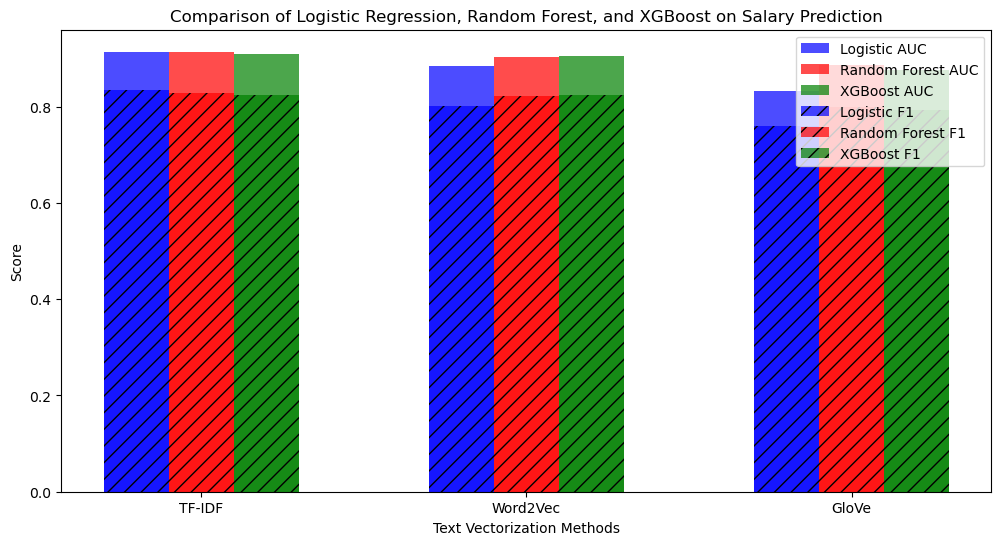

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score


def train_and_evaluate_xgb(X_train, X_test, y_train, y_test, method_name):
    model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_pred_prob)
    f1 = f1_score(y_test, y_pred)

    print(f"📌 XGBoost using {method_name}:")
    print(f"AUC: {auc:.4f}, F1-score: {f1:.4f}\n")

    return auc, f1


auc_tfidf_xgb, f1_tfidf_xgb = train_and_evaluate_xgb(X_train_tfidf, X_test_tfidf, y_train_max, y_test_max, "TF-IDF")

auc_w2v_xgb, f1_w2v_xgb = train_and_evaluate_xgb(X_train_w2v, X_test_w2v, y_train_max, y_test_max, "Word2Vec")

auc_glove_xgb, f1_glove_xgb = train_and_evaluate_xgb(X_train_glove, X_test_glove, y_train_max, y_test_max, "GloVe")


methods = ["TF-IDF", "Word2Vec", "GloVe"]
auc_logistic = [auc_tfidf, auc_w2v, auc_glove]
auc_rf = [auc_tfidf_rf, auc_w2v_rf, auc_glove_rf]
auc_xgb = [auc_tfidf_xgb, auc_w2v_xgb, auc_glove_xgb]

f1_logistic = [f1_tfidf, f1_w2v, f1_glove]
f1_rf = [f1_tfidf_rf, f1_w2v_rf, f1_glove_rf]
f1_xgb = [f1_tfidf_xgb, f1_w2v_xgb, f1_glove_xgb]

x = np.arange(len(methods))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - width, auc_logistic, width, label="Logistic AUC", color="blue", alpha=0.7)
plt.bar(x, auc_rf, width, label="Random Forest AUC", color="red", alpha=0.7)
plt.bar(x + width, auc_xgb, width, label="XGBoost AUC", color="green", alpha=0.7)
plt.bar(x - width, f1_logistic, width, label="Logistic F1", color="blue", hatch="//", alpha=0.7)
plt.bar(x, f1_rf, width, label="Random Forest F1", color="red", hatch="//", alpha=0.7)
plt.bar(x + width, f1_xgb, width, label="XGBoost F1", color="green", hatch="//", alpha=0.7)

plt.xticks(x, methods)
plt.xlabel("Text Vectorization Methods")
plt.ylabel("Score")
plt.title("Comparison of Logistic Regression, Random Forest, and XGBoost on Salary Prediction")
plt.legend()
plt.show()


c:\Users\25645\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\25645\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\25645\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\25645\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\25645\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

[LightGBM] [Info] Number of positive: 11601, number of negative: 12232
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.633055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 676396
[LightGBM] [Info] Number of data points in the train set: 23833, number of used features: 4963
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486762 -> initscore=-0.052964
[LightGBM] [Info] Start training from score -0.052964
📌 LightGBM using TF-IDF:
AUC: 0.9301, F1-score: 0.8500

[LightGBM] [Info] Number of positive: 11601, number of negative: 12232
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.215754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 23833, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486762 -> initscore=-0.052964
[Lig

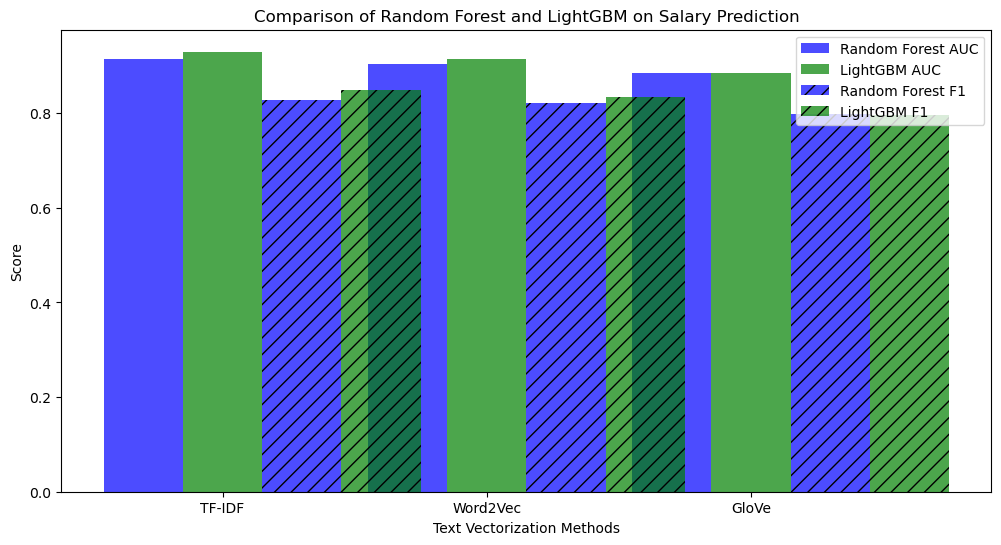

In [ ]:
import lightgbm as lgb
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

def train_and_evaluate_lgb(X_train, X_test, y_train, y_test, method_name):

    model = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] 

    auc = roc_auc_score(y_test, y_pred_prob)
    f1 = f1_score(y_test, y_pred)

    print(f"📌 LightGBM using {method_name}:")
    print(f"AUC: {auc:.4f}, F1-score: {f1:.4f}\n")

    return auc, f1

auc_tfidf_lgb, f1_tfidf_lgb = train_and_evaluate_lgb(X_train_tfidf, X_test_tfidf, y_train_max, y_test_max, "TF-IDF")

auc_w2v_lgb, f1_w2v_lgb = train_and_evaluate_lgb(X_train_w2v, X_test_w2v, y_train_max, y_test_max, "Word2Vec")

auc_glove_lgb, f1_glove_lgb = train_and_evaluate_lgb(X_train_glove, X_test_glove, y_train_max, y_test_max, "GloVe")

methods = ["TF-IDF", "Word2Vec", "GloVe"]
auc_rf = [auc_tfidf_rf, auc_w2v_rf, auc_glove_rf]  
auc_lgb = [auc_tfidf_lgb, auc_w2v_lgb, auc_glove_lgb]  
f1_rf = [f1_tfidf_rf, f1_w2v_rf, f1_glove_rf]
f1_lgb = [f1_tfidf_lgb, f1_w2v_lgb, f1_glove_lgb]

x = np.arange(len(methods))
width = 0.3

plt.figure(figsize=(12, 6))
plt.bar(x - width, auc_rf, width, label="Random Forest AUC", color="blue", alpha=0.7)
plt.bar(x, auc_lgb, width, label="LightGBM AUC", color="green", alpha=0.7)
plt.bar(x + width, f1_rf, width, label="Random Forest F1", color="blue", hatch="//", alpha=0.7)
plt.bar(x + 2*width, f1_lgb, width, label="LightGBM F1", color="green", hatch="//", alpha=0.7)

plt.xticks(x, methods)
plt.xlabel("Text Vectorization Methods")
plt.ylabel("Score")
plt.title("Comparison of Random Forest and LightGBM on Salary Prediction")
plt.legend()
plt.show()


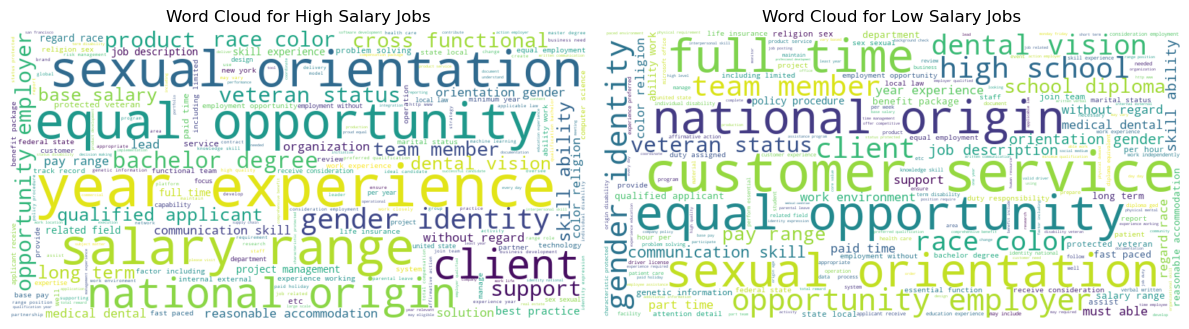

In [17]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords

# Define salary thresholds
high_salary_threshold = df['max_salary'].quantile(0.75)  # Top 25% highest salary
low_salary_threshold = df['min_salary'].quantile(0.25)   # Bottom 25% lowest salary

# Separate job descriptions into high and low salary categories
high_salary_jobs = df[df['max_salary'] >= high_salary_threshold]['clean_desc'].dropna()
low_salary_jobs = df[df['min_salary'] <= low_salary_threshold]['clean_desc'].dropna()

# Join all job descriptions in each category
high_salary_text = " ".join(high_salary_jobs)
low_salary_text = " ".join(low_salary_jobs)

# Stopwords (remove common words that add no value)
stop_words = set(stopwords.words('english'))

# Generate WordCloud for high-salary jobs
high_salary_wc = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(high_salary_text)

# Generate WordCloud for low-salary jobs
low_salary_wc = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(low_salary_text)

# Plot the WordClouds
plt.figure(figsize=(12, 5))

# High Salary Word Cloud
plt.subplot(1, 2, 1)
plt.imshow(high_salary_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for High Salary Jobs")

# Low Salary Word Cloud
plt.subplot(1, 2, 2)
plt.imshow(low_salary_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Low Salary Jobs")

plt.tight_layout()
plt.show()


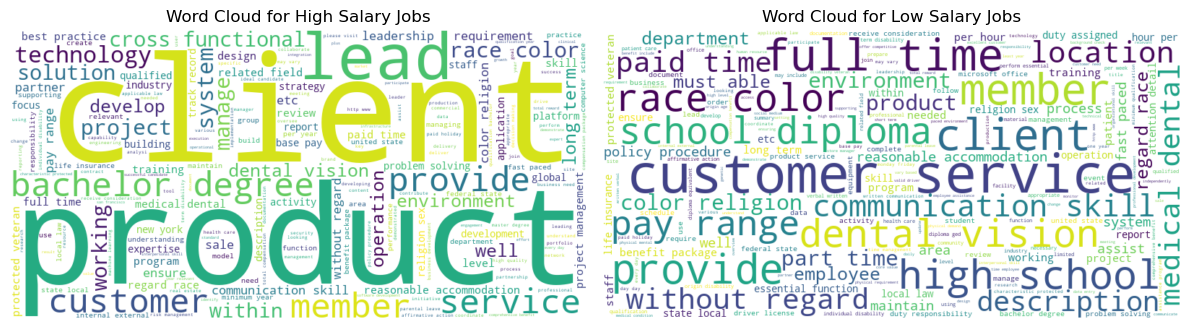

In [18]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords

# Define salary thresholds
high_salary_threshold = df['max_salary'].quantile(0.75)  # Top 25% highest salary
low_salary_threshold = df['min_salary'].quantile(0.25)   # Bottom 25% lowest salary

# Separate job descriptions into high and low salary categories
high_salary_jobs = df[df['max_salary'] >= high_salary_threshold]['clean_desc'].dropna()
low_salary_jobs = df[df['min_salary'] <= low_salary_threshold]['clean_desc'].dropna()

# Join all job descriptions in each category
high_salary_text = " ".join(high_salary_jobs)
low_salary_text = " ".join(low_salary_jobs)

# Stopwords (remove common words that add no value)
stop_words = set(stopwords.words('english'))

# Add domain-specific stopwords
custom_stopwords = {
    "responsibilities", "qualifications", "company", "position", "applicant",
    "employer", "team", "opportunity", "role", "including", "support",
    "status", "experience", "education", "requirements", "skills",
    "work", "ability", "job", "organization", "information", "employment","opportunity","experience",
    "benefits", "knowledge", "strong", "required", "preferred", "equal", "salary","sexual","orientation","gender",
    "identity","national"
}

stop_words.update(custom_stopwords)

# Generate WordCloud for high-salary jobs
high_salary_wc = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(high_salary_text)

# Generate WordCloud for low-salary jobs
low_salary_wc = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(low_salary_text)

# Plot the WordClouds
plt.figure(figsize=(12, 5))

# High Salary Word Cloud
plt.subplot(1, 2, 1)
plt.imshow(high_salary_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for High Salary Jobs")

# Low Salary Word Cloud
plt.subplot(1, 2, 2)
plt.imshow(low_salary_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Low Salary Jobs")

plt.tight_layout()
plt.show()


In [ ]:
import lightgbm as lgb
import pickle
from sklearn.model_selection import train_test_split

# Select relevant columns
df = df[['clean_desc', 'max_salary', 'min_salary']].dropna()

# Convert salary into regression target
y_max = df["max_salary"]
y_min = df["min_salary"]

# Split data for training
X_train, X_test, y_train_max, y_test_max = train_test_split(df['clean_desc'], y_max, test_size=0.2, random_state=42)
X_train, X_test, y_train_min, y_test_min = train_test_split(df['clean_desc'], y_min, test_size=0.2, random_state=42)



vectorizer_tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

# Save the TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as tfidf_file:
    pickle.dump(vectorizer_tfidf, tfidf_file)



# Train LightGBM for max_salary
lgbm_model_max = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
lgbm_model_max.fit(X_train_tfidf, y_train_max)

# Train LightGBM for min_salary
lgbm_model_min = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
lgbm_model_min.fit(X_train_tfidf, y_train_min)

with open("lightgbm_model_max.pkl", "wb") as model_max_file:
    pickle.dump(lgbm_model_max, model_max_file)

with open("lightgbm_model_min.pkl", "wb") as model_min_file:
    pickle.dump(lgbm_model_min, model_min_file)

print(" Models and vectorizer saved successfully!")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.215127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 676396
[LightGBM] [Info] Number of data points in the train set: 23833, number of used features: 4963
[LightGBM] [Info] Start training from score 10127.220336
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.738966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 676396
[LightGBM] [Info] Number of data points in the train set: 23833, number of used features: 4963
[LightGBM] [Info] Start training from score 7406.383630
✅ Models and vectorizer saved successfully!
